# What I'll analise?

I've come up with a few questions that need answers:
- What is the average number of viewers at every hour in the day?
- Which game is the most popular in Poland and how popular? Compared to internationally
- What is the percentage of Polish streamers in streamers recorded?
- Who are the top 10 streamers based on average viewership?
- What is the average number of viewers per game in every hour in the day?
- What is the distribution of spoken languages per game?



# Setting constants, and establishing DB connection

In [113]:
import psycopg2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 10]

def get_colnames(cursor):
    """
    Extracts column names from the cursor 
    """
    indexes = []
    for i in cursor.description:
        indexes.append(i.name)
    
    return indexes

def exec_query_to_df(query, cursor):
    """
    Executes query and returns a pandas data frame
    """
    
    cursor.execute(query)
    res = cursor.fetchall()
    col_names = get_colnames(cur)

    df = pd.DataFrame(res, columns = col_names)
    
    return df
    
    

scraping_db = {'name':'Scraping',
               'user':'read_only_scraping',
               'password':'Nowypass12',
               'host':'193.187.69.29'}

conn = psycopg2.connect(dbname=scraping_db['name'], user=scraping_db['user'],
                        password=scraping_db['password'], host=scraping_db['host'])
cur = conn.cursor()

# 1. What is the average number of viewers at every hour in the day?

In [114]:
# I have to use CAST here because hours will be on the x axis and have to be int

query = """
SELECT CAST(date_part('hour', s.recorded_at) AS INTEGER) AS "hour_in_the_day", 
    ROUND(AVG(s.viewers),2) AS "avg_viewers"
FROM good_stream_data s
JOIN games g 
ON g.id = s.game_id
GROUP BY 1
ORDER BY 1
"""

df = exec_query_to_df(query, cur)

In [115]:
df

,hour_in_the_day,avg_viewers
0,0,10091.51
1,1,8857.78
2,2,7025.19
3,3,6084.50
4,4,5237.00
5,5,4718.80
6,6,4281.35
7,7,3886.00
8,8,3589.11
9,9,3585.85


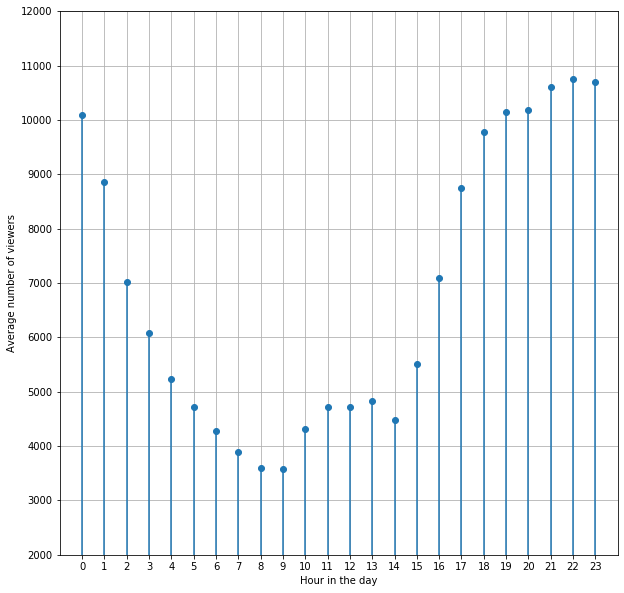

In [116]:
plt.stem(df['hour_in_the_day'], df['avg_viewers'], use_line_collection = True)
plt.axis([-1,24,2000,12000])
plt.xticks(range(0,24))
plt.yticks([2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000])
plt.xlabel('Hour in the day')
plt.ylabel('Average number of viewers')
plt.grid()
plt.show()

# Interpretation

The number of viewers increases from 5PM until 10PM, it hovers around the same level at 11PM and then starts to go down. Based on some research (https://sproutsocial.com/insights/best-times-to-post-on-social-media/) during the COVID-19 pandemic we can assume that the peak times on social media are between 9AM and 4PM. That would mean that the most viewers on twitch are in the GMT-8 time zone. Probably the USA. We can check that by plotting again, this time with PST and EST timezones for the west coast and the east coast of the US respectively. 

In [117]:
queryEST = """
SELECT CAST(date_part('hour', s.recorded_at - INTERVAL '6 hours') AS INTEGER) AS "hour_in_the_day", 
    ROUND(AVG(s.viewers),2) AS "avg_viewers"
FROM good_stream_data s
JOIN games g 
ON g.id = s.game_id
GROUP BY 1
ORDER BY 1
"""

dfEST = exec_query_to_df(queryEST, cur)

queryPST = """
SELECT CAST(date_part('hour', s.recorded_at - INTERVAL '9 hours') AS INTEGER) AS "hour_in_the_day", 
    ROUND(AVG(s.viewers),2) AS "avg_viewers"
FROM good_stream_data s
JOIN games g 
ON g.id = s.game_id
GROUP BY 1
ORDER BY 1
"""

dfPST = exec_query_to_df(queryPST, cur)

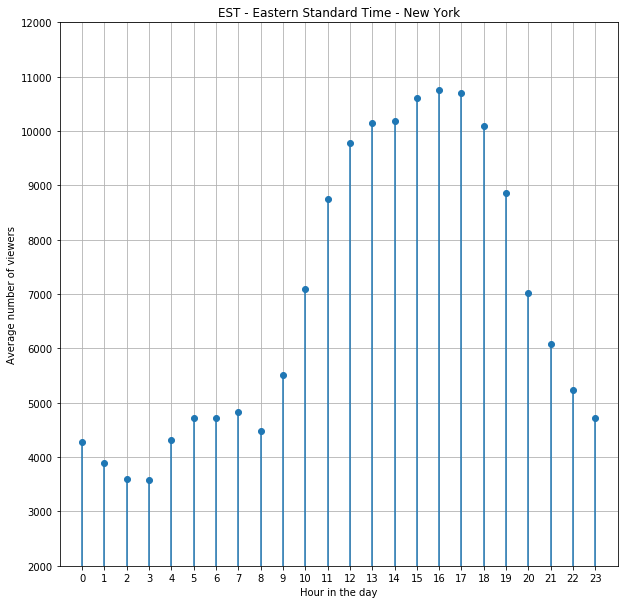

In [118]:
plt.stem(dfEST['hour_in_the_day'], dfEST['avg_viewers'], use_line_collection = True)
plt.axis([-1,24,2000,12000])
plt.xticks(range(0,24))
plt.yticks([2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000])
plt.grid()
plt.xlabel('Hour in the day')
plt.ylabel('Average number of viewers')
plt.title('EST - Eastern Standard Time - New York')
plt.show()

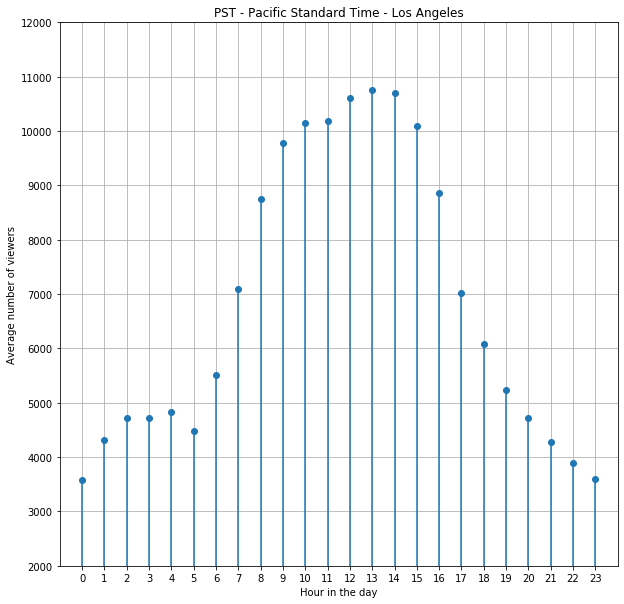

In [119]:
plt.stem(dfPST['hour_in_the_day'], dfPST['avg_viewers'], use_line_collection = True)
plt.axis([-1,24,2000,12000])
plt.xticks(range(0,24))
plt.yticks([2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000])
plt.grid()
plt.xlabel('Hour in the day')
plt.ylabel('Average number of viewers')
plt.title('PST - Pacific Standard Time - Los Angeles')
plt.show()

# Conclusion

We can assume with a dose of certainty that most of the viewers on twitch.tv come from the US. Of course we would need more data to be sure, but we can make an educated guess. 

# 2. Which game is the most popular in Poland and how popular? Compared to internationally

In [120]:
query = """
SELECT g.name, ROUND(AVG(s.viewers),2) AS "avg_viewers"
FROM good_stream_data s
JOIN games g 
ON g.id = s.game_id
AND stream_language = 'Polish'
GROUP BY 1
ORDER BY 2 DESC
"""

df = exec_query_to_df(query, cur)

In [121]:
df

,name,avg_viewers
0,League of Legends,8201.00
1,Fortnite,7520.36
2,Grand Theft Auto V,4474.00
3,Minecraft,4184.46
4,Counter Strike: Globbal Offensive,2921.37


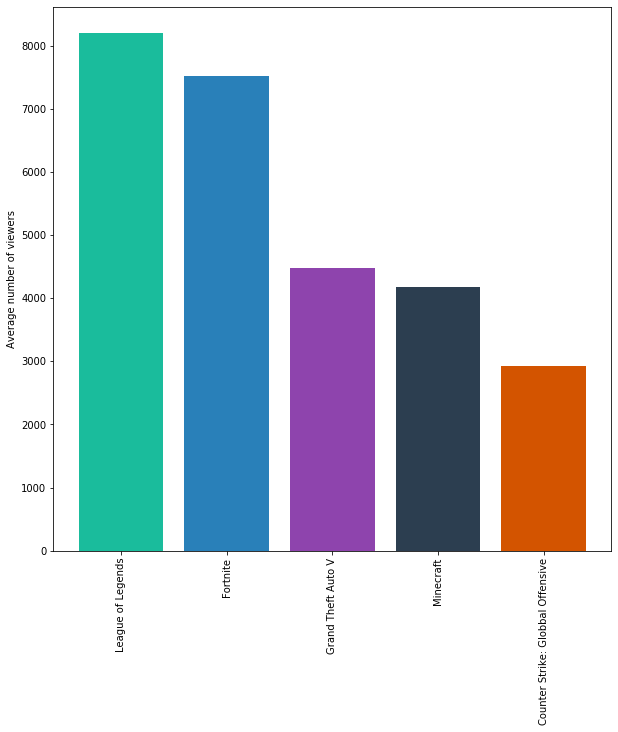

In [122]:
plt.bar(df['name'], df['avg_viewers'], color = ['#1abc9c', '#2980b9', '#8e44ad', '#2c3e50', '#d35400'])
plt.ylabel('Average number of viewers')
plt.xticks(rotation = 90)
plt.show()

# Interpretation

As we can see - League of Legends and Fortnite dominate the other games in Poland. Let's look at how this stacks up with international popularity.

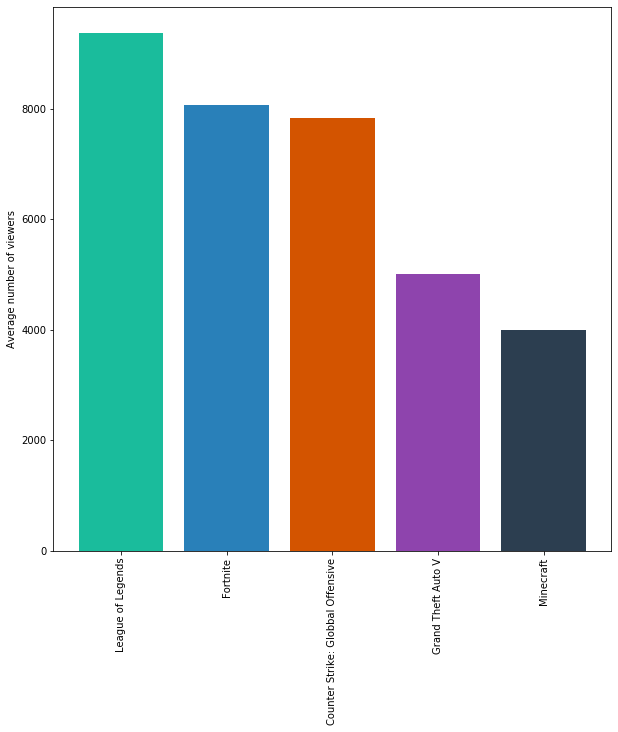

In [123]:
query = """
SELECT g.name, ROUND(AVG(s.viewers),2) AS "avg_viewers"
FROM good_stream_data s
JOIN games g 
ON g.id = s.game_id
GROUP BY 1
ORDER BY 2 DESC
"""

df = exec_query_to_df(query, cur)

plt.bar(df['name'], df['avg_viewers'], color = ['#1abc9c', '#2980b9', '#d35400', '#8e44ad', '#2c3e50'])
plt.ylabel('Average number of viewers')
plt.xticks(rotation = 90)
plt.show()

# Conclusion

When comparing the international data and Polish data, we can see that CS:GO is almost twice as popular worldwide. This would be interesting to analise further, maybe it has something to do with Polish teams not performing or Polish people just got bored of CS:GO as it's peak popularity was about 2-3 years ago.



# 3. What is the percentage of Polish streamers in all of the top streamers recorded?

In [124]:
query = """
SELECT (CAST((SELECT COUNT(*)
        FROM streamers
        WHERE native_language = 'Polish') AS FLOAT) / CAST(COUNT(*) AS FLOAT) * 100) AS PL_streamers_pct
FROM streamers

"""

df = exec_query_to_df(query, cur)

df

,pl_streamers_pct
0,1.086957


In [127]:
query = """
SELECT COUNT(*) as PL_streamers_count
FROM streamers
WHERE native_language = 'Polish'
"""

df = exec_query_to_df(query, cur)

df

,pl_streamers_count
0,34


In [129]:
query = """
SELECT COUNT(*) as all_streamers_count
FROM streamers
"""

df = exec_query_to_df(query, cur)

df

,all_streamers_count
0,3128


# Conclusion

As we can see, the Polish streamers represent only 1,09% of all streamers recorded. That tells us that the data that we have on Polish streaming scene may not be accurate. I would have to collect more data specifically from Polish streamers.



# 4. Who are the top 10 streamers based on average viewership?

In [138]:
query = """
SELECT s.twitch_name, ROUND(AVG(gs.viewers),0) as avg_viewers
FROM good_stream_data gs
JOIN streamers s
ON gs.streamer_id = s.id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
"""

df = exec_query_to_df(query, cur)

df

,twitch_name,avg_viewers
0,FASTCUP_NET,136197
1,fastcup_net,80467
2,Rubius,72263
3,auronplay,72230
4,LEC,67487
5,Mibrtv,58214
6,LCK_Korea,51805
7,s1mplevznh,49731
8,Tfue,48304
9,s1mplekpbx,48148


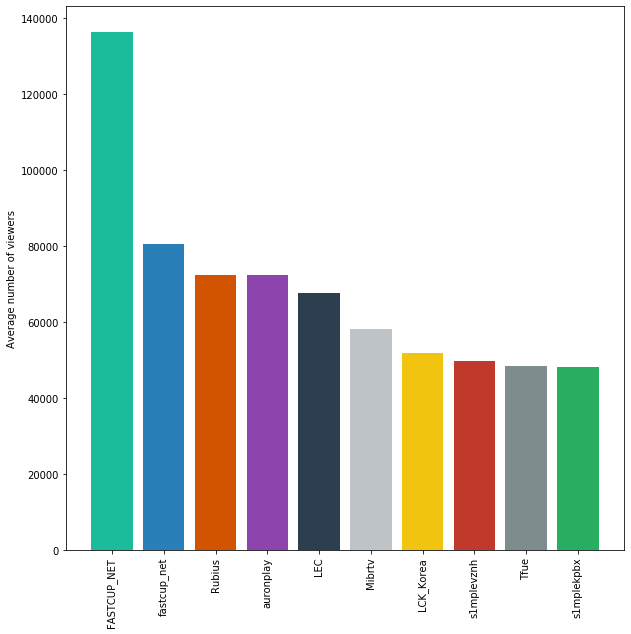

In [139]:
colors = ['#1abc9c', '#2980b9', '#d35400', '#8e44ad', '#2c3e50', '#bdc3c7', '#f1c40f', '#c0392b', '#7f8c8d', '#27ae60']
plt.bar(df['twitch_name'], df['avg_viewers'], color = colors)
plt.ylabel('Average number of viewers')
plt.xticks(rotation = 90)
plt.show()

And without FASTCUP_NET which is the clear outlier:

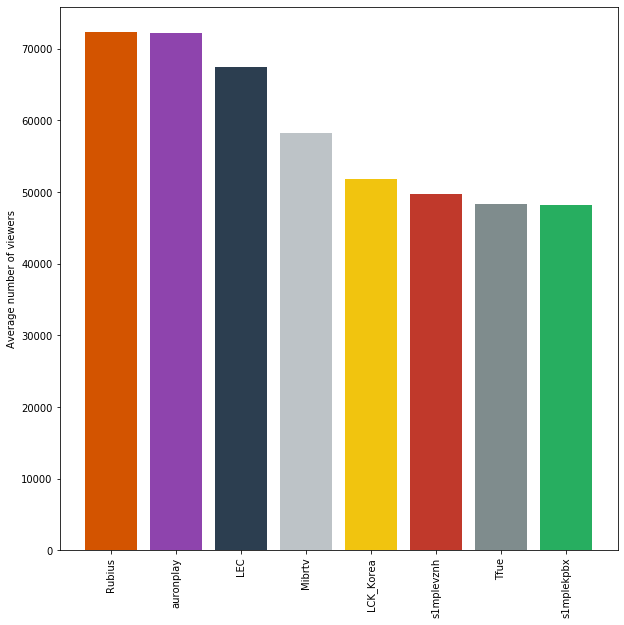

In [141]:
df = df.drop([0,1])
colors = ['#d35400', '#8e44ad', '#2c3e50', '#bdc3c7', '#f1c40f', '#c0392b', '#7f8c8d', '#27ae60']
plt.bar(df['twitch_name'], df['avg_viewers'], color = colors)
plt.ylabel('Average number of viewers')
plt.xticks(rotation = 90)
plt.show()

# Conclusion

We can see that the average viewership among the top 10 streamers with highest viewers drops around 30% from #1 place to #10 place



# 5. What is the average number of viewers per game in every hour in the day?

Here I'll have to write a bit of code, so you can skip to the plot. I'll also be using PST time.

In [155]:
base_query = """
SELECT date_part('hour', s.recorded_at - INTERVAL '9 hours') AS "hour_in_the_day", ROUND(AVG(s.viewers),2) AS "avg_viewers"
FROM good_stream_data s
JOIN games g 
ON g.id = s.game_id
AND g.name = '{s}'
GROUP BY 1
ORDER BY 1
"""

q1 = base_query.format(s = 'League of Legends')
q2 = base_query.format(s = 'Fortnite')
q3 = base_query.format(s = 'Counter Strike: Globbal Offensive')
q4 = base_query.format(s = 'Minecraft')
q5 = base_query.format(s = 'Grand Theft Auto V')

dfLOL = exec_query_to_df(q1, cur)
dfFort = exec_query_to_df(q2, cur)
dfCSGO = exec_query_to_df(q3, cur)
dfMC = exec_query_to_df(q4, cur)
dfGTA = exec_query_to_df(q5, cur)



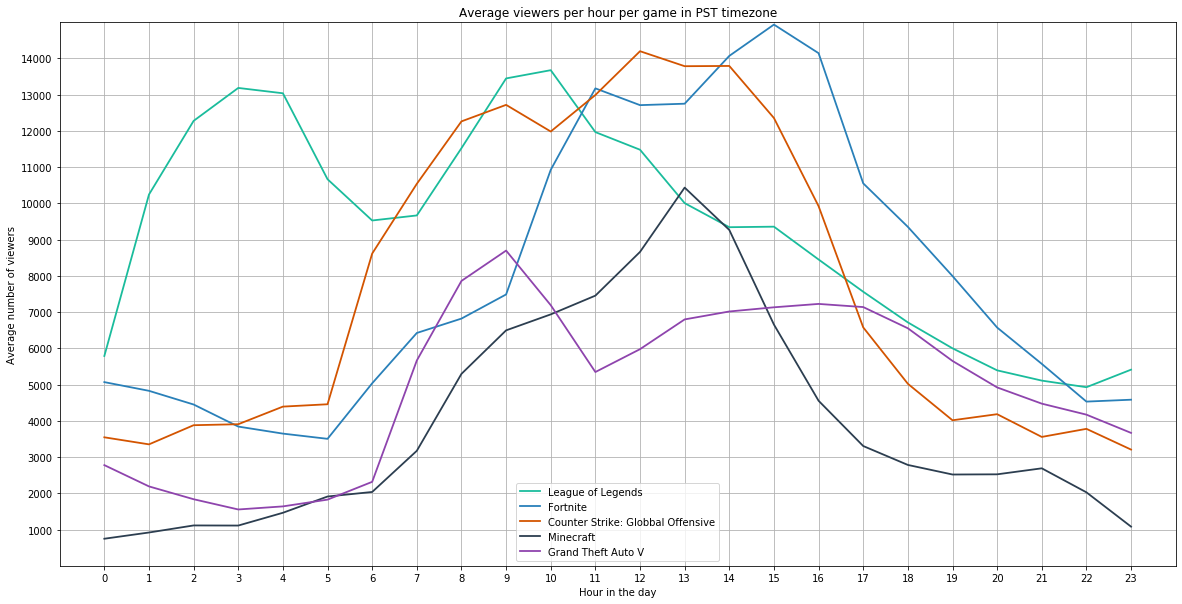

In [168]:
fig = plt.figure(figsize = (20,10))

color = ['#1abc9c', '#2980b9', '#d35400', '#8e44ad', '#2c3e50']

plt.plot(dfLOL['hour_in_the_day'], dfLOL['avg_viewers'], label = 'League of Legends', color = '#1abc9c', linewidth = 1.8)
plt.plot(dfFort['hour_in_the_day'], dfFort['avg_viewers'], label = 'Fortnite', color = '#2980b9', linewidth = 1.8)
plt.plot(dfCSGO['hour_in_the_day'], dfCSGO['avg_viewers'], label = 'Counter Strike: Globbal Offensive', color = '#d35400', linewidth = 1.8)
plt.plot(dfMC['hour_in_the_day'], dfMC['avg_viewers'], label = 'Minecraft', color = '#2c3e50', linewidth = 1.8)
plt.plot(dfGTA['hour_in_the_day'], dfGTA['avg_viewers'], label = 'Grand Theft Auto V', color = '#8e44ad', linewidth = 1.8)

plt.axis([-1,24,0,15000])
plt.xticks(range(0,24))
plt.yticks([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000])
plt.grid()
plt.xlabel('Hour in the day')
plt.ylabel('Average number of viewers')
plt.title('Average viewers per hour per game in PST timezone')
plt.legend(loc='lower center')

# Interpretation

From this chaotic mess of a plot, we can see that during the times when other games lose viewers, CS:GO gains them, so it may be a good idea to stream CS:GO at that time. We can also see that Fortnite has the highest peak number of average viewers at around 3PM PST. There are also times when Minecraft dips below 1000 average viewers and is the only game that has that low of a viewership.



# 6. What is the distribution of spoken languages per game?

In [276]:
base_query = """
SELECT t2.name as game, t2.native_language as language, SUM(t2.count) as count
FROM 	(SELECT t1.name, CASE WHEN COUNT(t1.native_language) < 10 THEN 'Other' ELSE t1.native_language END, COUNT(t1.native_language)
		FROM 	(SELECT DISTINCT(gs.streamer_id), g.name, s.native_language
				FROM good_stream_data gs
				JOIN streamers s
				ON gs.streamer_id = s.id
				JOIN games g
				ON g.id = gs.game_id
				ORDER BY 1) as t1
		GROUP BY t1.name, t1.native_language
		ORDER BY 1, 2) t2
GROUP BY 1, 2
ORDER BY 1, 2
"""
dfTest = exec_query_to_df(base_query, cur)

#dfTest = dfTest.set_index(['game','language'])
#dfTest['count'] = dfTest['count'].astype(float)



q1 = base_query.format(s = 'League of Legends')
q2 = base_query.format(s = 'Fortnite')
q3 = base_query.format(s = 'Counter Strike: Globbal Offensive')
q4 = base_query.format(s = 'Minecraft')
q5 = base_query.format(s = 'Grand Theft Auto V')

dfLOL = exec_query_to_df(q1, cur)
dfFort = exec_query_to_df(q2, cur)
dfCSGO = exec_query_to_df(q3, cur)
dfMC = exec_query_to_df(q4, cur)
dfGTA = exec_query_to_df(q5, cur)

In [280]:
#dfTest.unstack().plot(kind = 'bar', stacked = True)

dfTest['language'] == 'English'

KeyError: "['game' 'language' 'count'] not found in axis"